### Visualize spark "matrix" data in Power BI
#### Problem statement
You get IoT data which containes a matrix per row. A matrix can be visualized through a 3d-graph or a heatmap (in e.g. Power BI).<br>
The requirement is to create a data structure (from what we get from the IoT devices) that could be easily consumed by BI tools like Power BI.

#### Exmape data structure
The exmaple data is simple:
- id: is the unique id of the transmitting IoT device
- matrixdata: is the matrix values (like the Z-axis in a 3-d plot / heatmap)
- x_value: are the x_value for the Z-axis values
- y_value: are the y_value for the Z-axis values
- HINT: By using the index for the x_coord and the y_coord we get the value of the x, y and z for our plot

```
Example:

Matrix (z-values)
[0,1,2,3,4]
[1,2,3,4,5]
[2,3,4,5,6]
[1,2,3,4,5]
[0,1,2,3,4]

x_values = [0,20,50,80,150]
y_values = [10,30,60,80,110]

We would get x = 0, y = 10 and z = 0 (You find 0 on index (0,0) in the matrix)

So for each row in spark we have a matrix, array of x values and an array of y values.
The way the matrix would be represented in spark when we get the data (originally from json) would be through arrays in arrays:
```
<img src="https://datamh.blob.core.windows.net/public/SparkMatrixVectors1.png" alt="drawing" width="800"/>

Our task is to create a spark transformation so we can us the data in Power BI.
Power BI usually likes tabular data. So the idea is to create a stucture that looks like a normal table.
E.g.:
```
[id ][X-value] [y-value] [z-value] [meta-data-column(s)]
1000    0        10         0         meta-data
1000   20        30         2         meta-data
... for all index posisions of x, y
```

This would duplicate a lot of data, but would give us a table view of the more compact form of a matrix with two vectors above.

In [0]:
# Flag to trigger file export
export_csv = False
# mounted path for export of the csv file
path_export = "/mnt/datasetsneugen2/PowerBI"

In [0]:
import pandas as pd
# Generate test data with the structure described above
df_arr = pd.DataFrame(
  {'id': [1000, 2000],
  'matrixdata': [[[0, 1, 1, 1, 0],[1,3,3, 3,1], [0,2,2, 2,0],[0, 1, 1, 1, 0], [0, 1, 2, 1, 0]],\
                 [[0, 1,1,1, 1],[1,5,5,5,1], [1,2,3,2,1],[0, 1, 2,1, 0], [0, 1, 2,1, 0]]],
  'x_values': [[0, 40,75, 100, 150],[0, 40, 75, 100, 150]],
  'y_values': [[10,40,70, 80, 110], [10,40,70, 80, 110]]
  })
dfSpark = spark.createDataFrame(df_arr)
display(dfSpark)

id,matrixdata,x_values,y_values
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)"


In [0]:
from pyspark.sql.functions import posexplode
# Explode the x array and the y array and use posexplode so that we know
# from what index each, x- and y-value comes from. We need the index 
# to map pairs of x,y to the correct value/postion in the matrix containing the z-values.
dfExploded1 = dfSpark.select("id", "matrixdata", "x_values",\
                             "y_values", posexplode("matrixdata"))\
.withColumnRenamed("pos", "y_index").withColumnRenamed("col", "values")
display(dfExploded1)

id,matrixdata,x_values,y_values,y_index,values
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)"
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)"
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",2,"List(0, 2, 2, 2, 0)"
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",3,"List(0, 1, 1, 1, 0)"
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",4,"List(0, 1, 2, 1, 0)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 1)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 5, 5, 5, 1)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",2,"List(1, 2, 3, 2, 1)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",3,"List(0, 1, 2, 1, 0)"
2000,"List(List(0, 1, 1, 1, 1), List(1, 5, 5, 5, 1), List(1, 2, 3, 2, 1), List(0, 1, 2, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",4,"List(0, 1, 2, 1, 0)"


In [0]:
dfExploded2 = dfExploded1.select("id", "matrixdata", "x_values",\
                                 "y_values", "y_index", "values",\
                                 posexplode("values"))\
.withColumnRenamed("pos", "x_index").withColumnRenamed("col", "z_value")
display(dfExploded2)

id,matrixdata,x_values,y_values,y_index,values,x_index,z_value
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)",0,0
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)",1,1
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)",2,1
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)",3,1
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",0,"List(0, 1, 1, 1, 0)",4,0
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)",0,1
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)",1,3
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)",2,3
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)",3,3
1000,"List(List(0, 1, 1, 1, 0), List(1, 3, 3, 3, 1), List(0, 2, 2, 2, 0), List(0, 1, 1, 1, 0), List(0, 1, 2, 1, 0))","List(0, 40, 75, 100, 150)","List(10, 40, 70, 80, 110)",1,"List(1, 3, 3, 3, 1)",4,1


In [0]:
# Now extract x- and y-value using our idexes for each row and then we can
# use the data in an external tool as we have separate columns/dimensions 
# for the visualisation
from pyspark.sql.functions import col
dfExp3 = dfExploded2.withColumn("x_value", col("x_values")[col("x_index")])\
.withColumn("y_value", col("y_values")[col("y_index")])
# Lets drop the columns we dont need for the csv data export
dfExport = dfExp3.select("id", "x_value", "y_value", "z_value")\
.orderBy("id", "x_value", "y_value")
display(dfExport)
# Now we have a standard table view of our data that can be consumed by Power BI

id,x_value,y_value,z_value
1000,0,10,0
1000,0,40,1
1000,0,70,0
1000,0,80,0
1000,0,110,0
1000,40,10,1
1000,40,40,3
1000,40,70,2
1000,40,80,1
1000,40,110,1


In [0]:
# Export to CSV and display as heatmap in Power BI
dbutils.fs.mkdirs(path_export)
dfPanda = dfExport.toPandas()
if export_csv:
  dfPanda.to_csv(index=False, header=True,\
                 path_or_buf=f"/dbfs{path_export}/heatmap_from_spark.csv")
                           
# coalesce(1).write.format("csv").mode("overwrite").option("header","true").option("mapreduce.fileoutputcommitter.marksuccessfuljobs","false").save(path="/mnt/datasetsneugen2/PowerBI2")

#### A note about Pandas
We know we do not have any "big data" matrices and vectors so we allow us to use Pandas to export our Spark Dataframe as a named CSV.<br>
We could have exported the data as CSV directly from spark in a scalable way, but we would then get csv files named by spark and<br>
that would create some extra work when loading data in Power BI. So we choose to use Pandas here as it better fulfills our needs in this case.<br>
Also if we would have a huge amounts of data I would not suggest exporting it as csv to Power BI. In that case we should consume thet data<br>
in other ways like direct query against Databricks.<br>

### Visualize the data
```
We have three columns / dimensions in our data called x, y and Z.
There are different ways to visualize this kind of data.
We could use some kind of heatmap in Power BI, but I did not find any heatmap that fulfilled the requirements,
but there might exist som great plugins to Power BI that I´m not aware of?
So I went for using python scripting to visualize the data in Power BI.
```

In [0]:
# In the Power BI python script we will get a Pandas dataframe as an input
x_list = dfPanda['x_value'].tolist()
y_list = dfPanda['y_value'].tolist()
z_list = dfPanda['z_value'].tolist()

In [0]:
# Extract from spark to get data to visualize
# In our bar3d plot below we want 3 arrays with x, y and z values
from pyspark.sql.types import ArrayType
all_rows = dfExport.filter("id == 1000").collect()

# Using list comprehensions to create a list from rows
x_list = [row.x_value for row in all_rows]
y_list = [row.y_value for row in all_rows]
z_list = [row.z_value for row in all_rows]

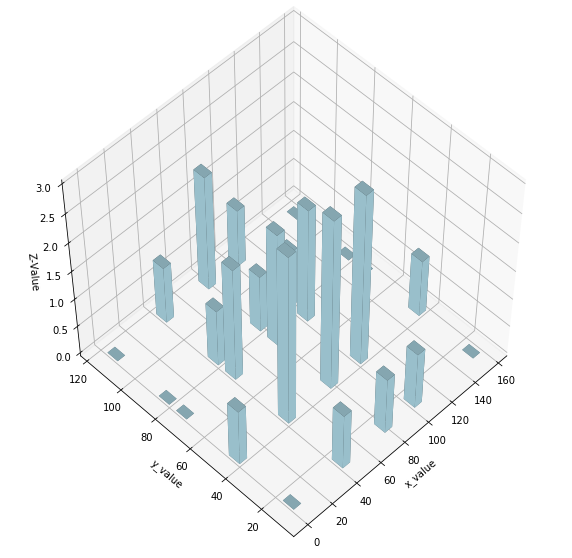

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
data_length = len(x_points)
ax.bar3d(x_list, y_list, 0, np.ones(data_length)+5,\
         np.ones(data_length)+5, z_list, color='lightblue');
# Set camera position and angle and labels
ax.view_init(elev=55., azim=135)
ax.view_init(ax.elev, ax.azim+90)
ax.set_xlabel('x_value')
ax.set_ylabel('y_value')
ax.set_zlabel('Z-Value')
plt.show()